**CV2021 - week 12**

**Contents**
* [K-Fold Cross Validation for LeNet](https://colab.research.google.com/drive/1KEz3NMY770VHP_lMv6-IYNGvPxJRvcpu#scrollTo=D4gJ8sNCM-5g&line=10&uniqifier=1)
* [AlexNet and data augmentation](https://colab.research.google.com/drive/1KEz3NMY770VHP_lMv6-IYNGvPxJRvcpu#scrollTo=-h2it_p8gSko&line=4&uniqifier=1)
* [VGG architecture](https://colab.research.google.com/drive/1KEz3NMY770VHP_lMv6-IYNGvPxJRvcpu#scrollTo=pmI9aC_fZOmP&line=3&uniqifier=1)
* [ResNet Architecture](https://colab.research.google.com/drive/1KEz3NMY770VHP_lMv6-IYNGvPxJRvcpu#scrollTo=XdTrU9fgPe5U)


**HOMEWORK**
* **1bp** Continue fitting the VGG transfer learning classifier on CIFAR 10.
Log training and testing statistics after each epoch. Discuss your results. 

* **1bp** Perform K-Fold CV on a sequence of models, aiming for polynomial regression over a dataset of synthetically generated data. Are the complexe models chosen over the simpler models? Why/ why not?
* **1bp** Use the simple LeNet demo to do transfer learning, classifying on the STL 10 dataset. Compare the transfer learning model performance with the one randomly initialized. 




**1. K-fold Cross Validation for LeNet**

In this task, we are going to code our version of *LeNet*, trained on **MNIST** dataset, and, as an approach for model selection and quality assessement, we are going to use the *k-flod cross-validation* procedure.

As discussed in  the previous weeks, the *MNIST* dataset does not provide a validation split, and a commom practice is to use the test data as validation data. However, doing *model selection* on the test split isnot a good practice, because the real-world data would have different characteristics and our model will not generalize as well as we would expect.
 
 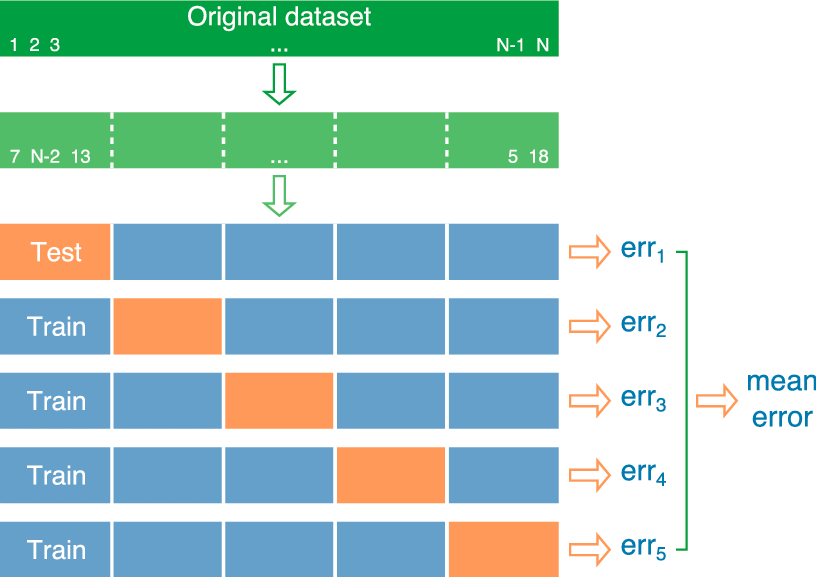




**Refereces**
* [K-fold cross validation](https://towardsdatascience.com/the-importance-of-k-fold-cross-validation-for-model-prediction-in-machine-learning-4709d3fed2ef)
* [LeNet](https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342)

In [ ]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


def get_mnist_data():
  (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
  X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
  X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
  Y_train = to_categorical(Y_train) # use one-hot encoding
  Y_test = to_categorical(Y_test)
  
  return X_train, Y_train, X_test, Y_test


In [ ]:
X_train, Y_train, X_test, Y_test = get_mnist_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
model = keras.Sequential()

# feature extraction stage
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())
# classification stage
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# let's define a callback to track the evolution of the model during training
# to detect overfitting, we will track accuracies for both training and test splits

from keras.callbacks import Callback


class TestCallback(Callback):
  def __init__(self, train_data, test_data, verbose=False):
    self.train_data = train_data
    self.test_data = test_data

    self.train_log = {}
    self.test_log = {}
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    x_train, y_train = self.train_data
    x_test, y_test = self.test_data

    train_loss, train_acc = self.model.evaluate(x_train, y_train, batch_size=32, verbose=0)
    test_loss, test_acc = self.model.evaluate(x_test, y_test, batch_size=32,  verbose=0)

    self.train_log[epoch] = train_acc
    self.test_log[epoch] = test_acc

    if self.verbose == True:
      log = 'E: {} - Train - Test loss: {} - {}, acc: {} - {}'.format(
              epoch, train_loss, test_loss, train_acc, test_acc)
      print(log)

In [ ]:
baseline_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
model.fit(X_train, Y_train, epochs=15, callbacks=baseline_callbacks, validation_data=(X_test, Y_test))

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0258 - accuracy: 0.9924 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.0216 - val_accuracy: 0.9935
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.0140 - val_accuracy: 0.9961
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0159 - val_accuracy: 0.9952
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0129 - val_accuracy: 0.9963
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0211 - val_accuracy: 0.9930
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.0060 - val_accuracy:

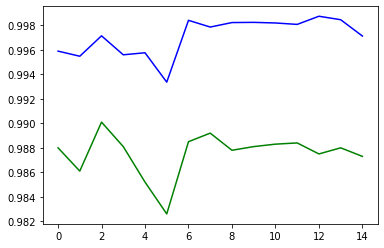

In [ ]:
import matplotlib.pyplot as plt


cb = baseline_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')

In [ ]:
# now, we will implement the k - fold CV procedure
from sklearn.model_selection import KFold

# 80% data for training, 20% for validation
models = []
kf = KFold(n_splits=5, random_state=None, shuffle=False)
current_split = 1
for train_index, test_index in kf.split(X_train):
  print("-----------STATISTICTS FOR SPLIT {}------------\n".format(current_split))
  # DEFINE THE MODEL 
  model = keras.Sequential()
  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
  model.add(AveragePooling2D())
  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())
  model.add(Flatten())
  model.add(Dense(units=120, activation='relu'))
  model.add(Dense(units=84, activation='relu'))
  model.add(Dense(units=10, activation = 'softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # DEFINE TRAIN/TEST data
  X_train_split, X_val_split = X_train[train_index], X_train[test_index]
  Y_train_split, Y_val_split = Y_train[train_index], Y_train[test_index]
  model.fit(X_train_split, Y_train_split, epochs=15, validation_data=(X_val_split, Y_val_split))
  # log the current state of themodelfor further use
  models.append(model)
  current_split += 1
  print("----------------------------------------------------------------------")


-----------STATISTICTS FOR SPLIT 1------------

Epoch 1/15
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5055 - accuracy: 0.8758 - val_loss: 0.0919 - val_accuracy: 0.9744
Epoch 2/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0735 - accuracy: 0.9777 - val_loss: 0.0691 - val_accuracy: 0.9788
Epoch 3/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0513 - accuracy: 0.9832 - val_loss: 0.0664 - val_accuracy: 0.9794
Epoch 4/15
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.0561 - val_accuracy: 0.9844
Epoch 5/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.0523 - val_accuracy: 0.9854
Epoch 6/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0488 - val_accuracy: 0.9859
Epoch 7/15
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0215 - acc

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification accuracy: 0.9878



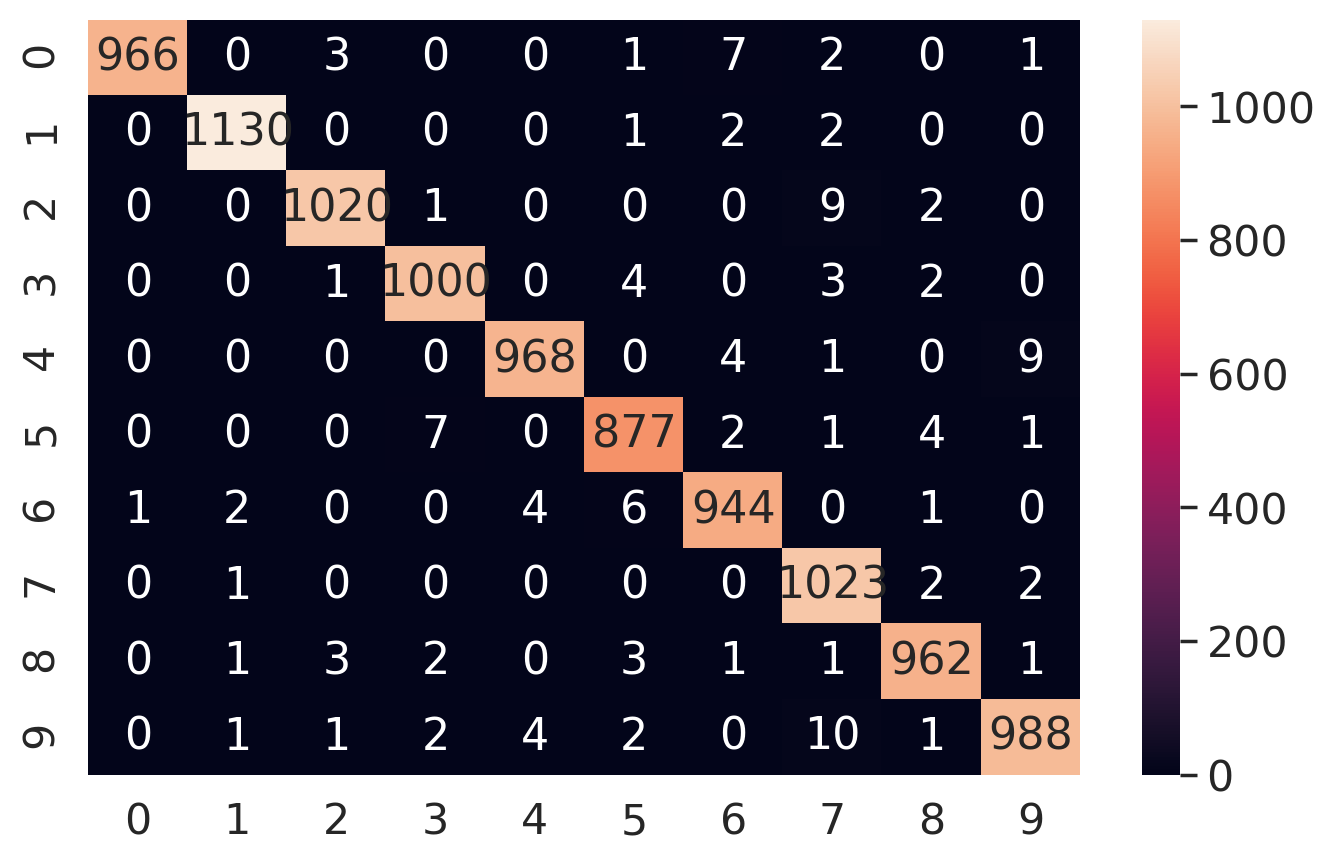

In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix


plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

(_, Y_train_arr), (_, Y_test_arr) = mnist.load_data()
predictions = models[1].predict_classes(X_test)
print("Classification accuracy: {}\n".format(accuracy_score(Y_test_arr, predictions)))

clf_confusion_matrix = confusion_matrix(Y_test_arr, predictions)
classes = [str(i) for i in range(10)]

df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
df_cmatrix.style.format("{:.1f}")


sn.set(font_scale=1.4) 
sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')

In [ ]:
for model in models:
  predictions = model.predict_classes(X_test)
  print("Classification accuracy: {}\n".format(accuracy_score(Y_test_arr, predictions)))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification accuracy: 0.988

Classification accuracy: 0.9878

Classification accuracy: 0.9898

Classification accuracy: 0.9851

Classification accuracy: 0.9881



**2. AlexNet**
In this task, we will experiment with a *keras* implementation of *AlexNet* and will discuss the data augmentation techniques deployed to overcome the difficulties give by the limited ammount of data we have available, when it comes to fully suppervised training. 

In this task, the used dataset will be the *CIFAR-10* dataset, linked in the set of references below the description of the task.  The *CIFAR-10* dataset consists of 60000 images, of 32x32 resolution, representing varoius animals and objects, grouped in 10 classes. The training split will use 50000 images, and the other 10000 will be used for testing.


**References**
* [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
* [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np

np.random.seed(1000)

AlexNet = Sequential()
# block 1
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#block 2
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#block 3
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#block 4
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#block 5
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

AlexNet.add(Flatten())
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.4))
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


In [ ]:
# this will plot a summary regarding the computation graph
AlexNet.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)        

In [ ]:
# load the CIFAR 10 data
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def load_cifar10_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  return x_train, x_test, y_train, y_test


In [ ]:
X_train, X_test, Y_train, Y_test = load_cifar10_data()


170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
baseline_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
AlexNet.fit(X_train, Y_train, epochs=50, callbacks=baseline_callbacks, validation_split=0.2)

170508288/170498071 [==============================] - 2s 0us/step
Epoch 1/50
1250/1250 [==============================] - 25s 15ms/step - loss: 1.8046 - accuracy: 0.3383 - val_loss: 2.4428 - val_accuracy: 0.2863
Epoch 2/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4264 - accuracy: 0.4925 - val_loss: 1.7644 - val_accuracy: 0.3642
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.2873 - accuracy: 0.5496 - val_loss: 1.7015 - val_accuracy: 0.4595
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1795 - accuracy: 0.5892 - val_loss: 1.6065 - val_accuracy: 0.4580
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0689 - accuracy: 0.6324 - val_loss: 1.2304 - val_accuracy: 0.5661
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9710 - accuracy: 0.6660 - val_loss: 1.8216 - val_accuracy: 0.4237
Epoch 7/50
1250/1250 [==============================] - 1

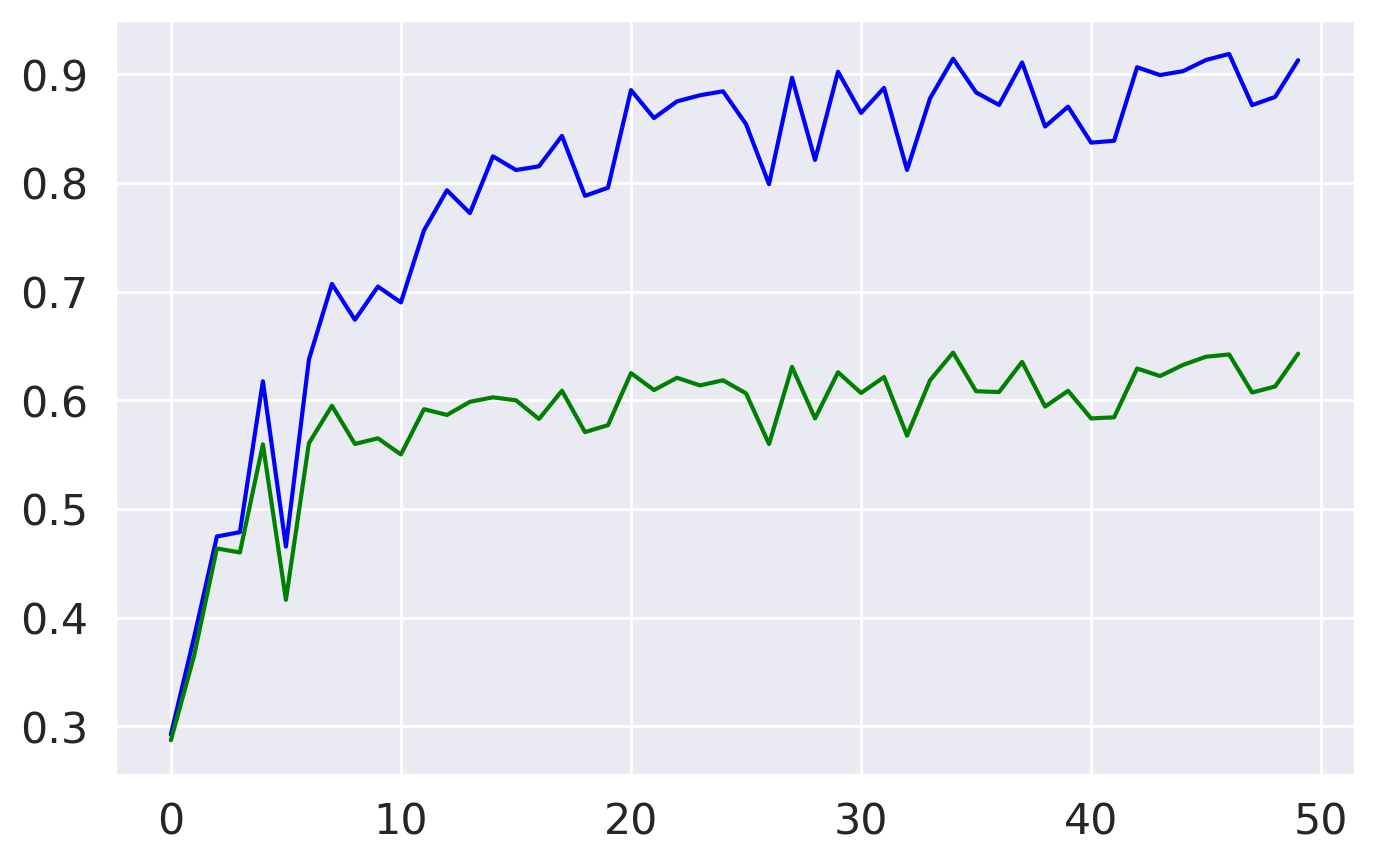

In [ ]:
cb = baseline_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')

In [ ]:
# now, we will implement a data augmentation strategy for our model
# in after training, we will see the evolution for both variants
# THE MODEL HAS TO BE REDEFINED BEFORE FITTING (re - run the cell with model definition)
from keras.preprocessing.image import ImageDataGenerator

# this will include random rotations, horizontal flips and zooming
train_generator = ImageDataGenerator(rotation_range=30, horizontal_flip=True, zoom_range=.1)
train_generator.fit(X_train)

augmentation_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test))]
AlexNet.fit(train_generator.flow(X_train, Y_train), epochs=50, callbacks=augmentation_callbacks)


Epoch 1/50
1563/1563 [==============================] - 34s 20ms/step - loss: 1.8373 - accuracy: 0.3193
Epoch 2/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.5519 - accuracy: 0.4414
Epoch 3/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4378 - accuracy: 0.4865
Epoch 4/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3529 - accuracy: 0.5166
Epoch 5/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.2976 - accuracy: 0.5420
Epoch 6/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.2395 - accuracy: 0.5627
Epoch 7/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1863 - accuracy: 0.5864
Epoch 8/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1351 - accuracy: 0.6061
Epoch 9/50
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1184 - accuracy: 0.6119
Epoch 10/50
1563/1563 [==============================] - 30s 19m

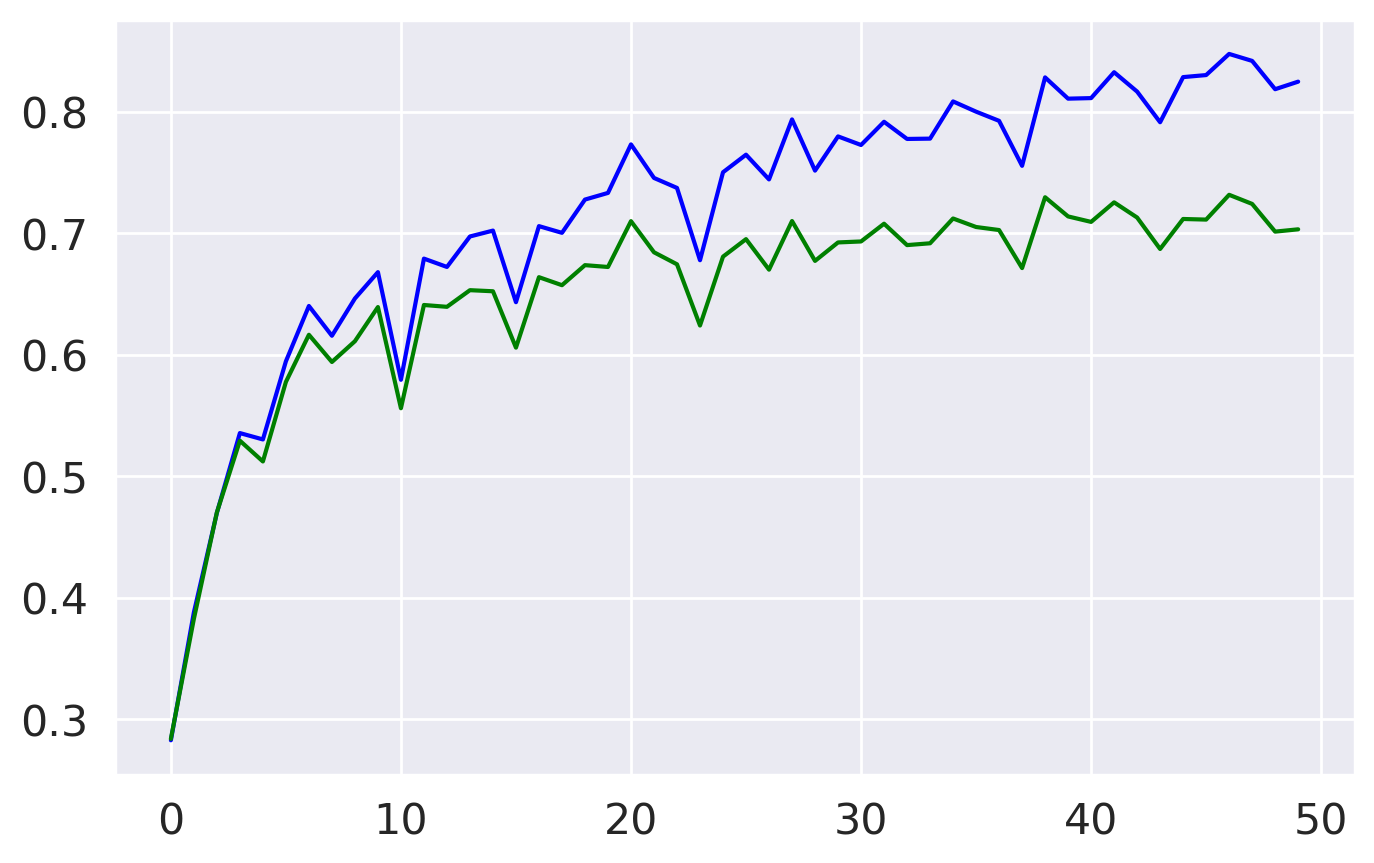

In [ ]:
cb = augmentation_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')

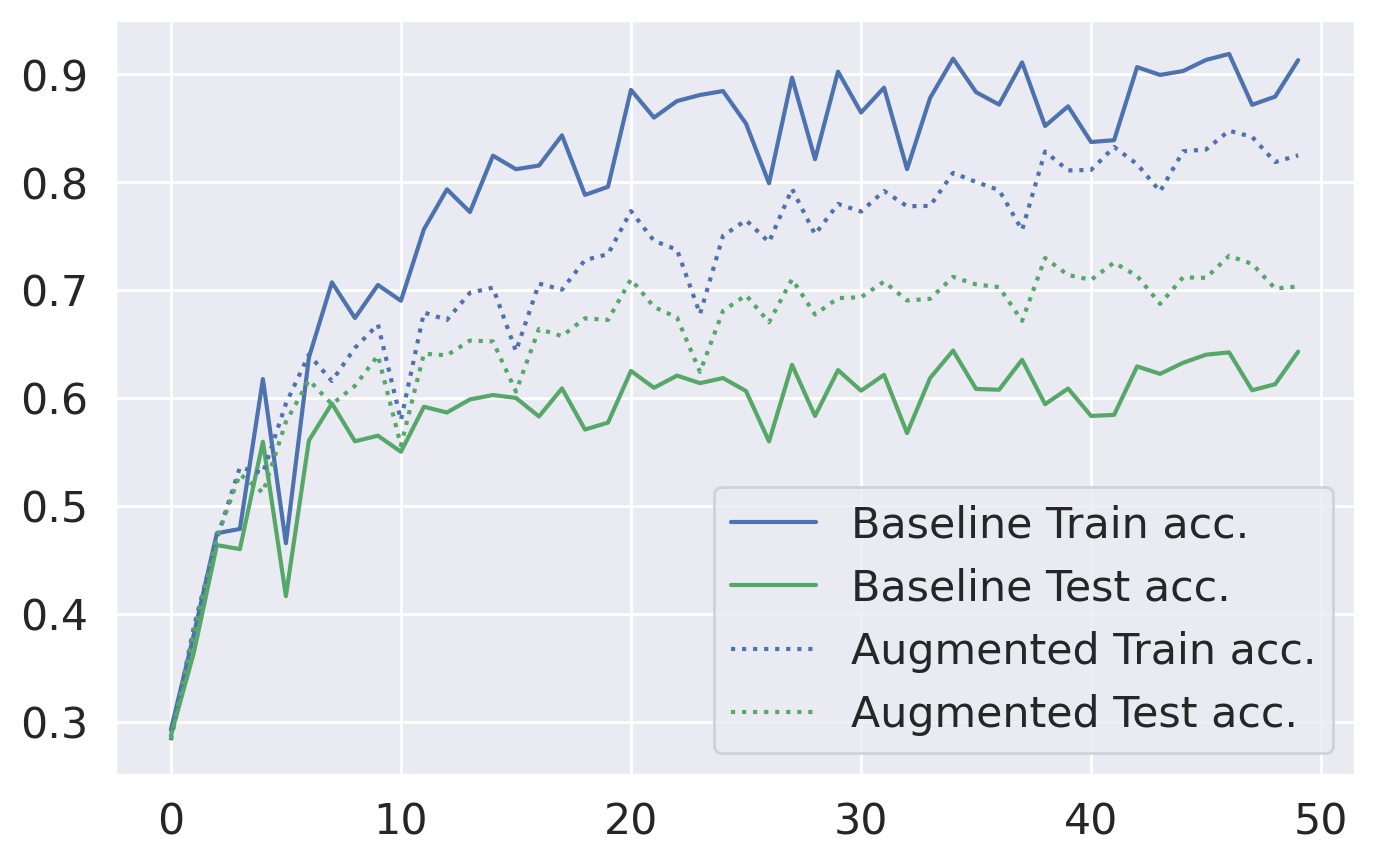

In [ ]:
cb = baseline_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b-', label='Baseline Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()),'g-', label='Baseline Test acc.')

cb = augmentation_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b:', label='Augmented Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()),'g:', label='Augmented Test acc.')
plt.legend()

**3. VGG Architecture**


Another architecture that won the ImageNet competition is the  VGG architecture. In the following picture, the VGG16 architecture was depicted.
 Similarly to the previous architectures, the VGG architecture consists of a feature extraction stage, followed by a fully-connectedlayers sequence, used for classification. In the last part of our demo, we will experiment with the concept of knowledge transfer (reusing the learnt weights for another task as a starting point for our current task).


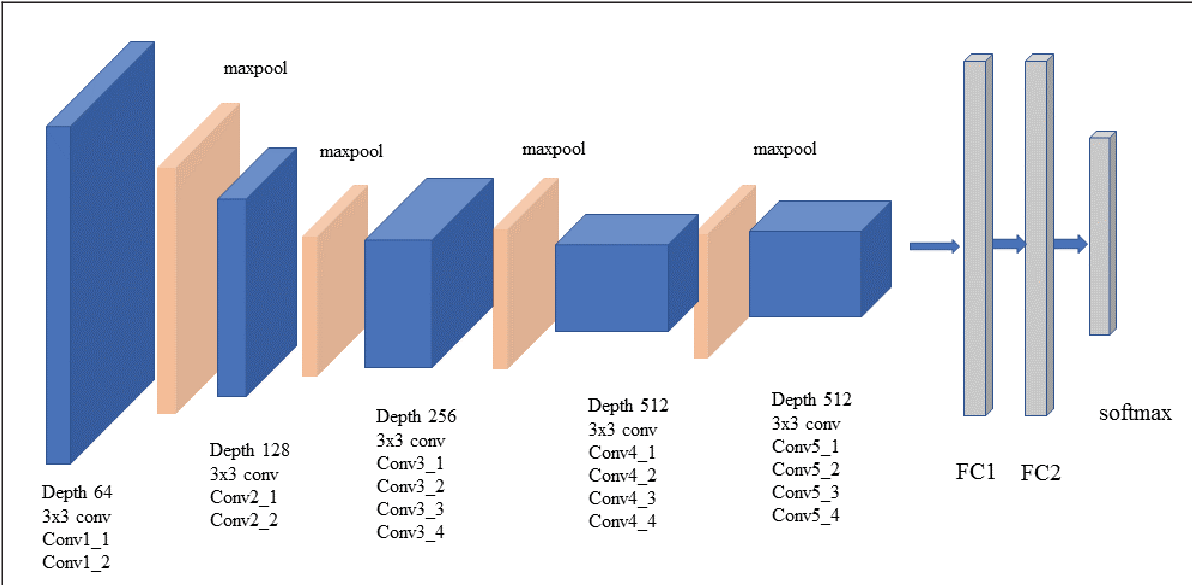

**References**
* [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)
* [VGG net in Keras](https://keras.io/api/applications/vgg/)

In [ ]:
from keras.applications.vgg19 import VGG19

# include top - strips the Classification stage, to allow for transfer learning
base_model = VGG19(include_top=False, weights=None, input_shape=(32,32,3),classes=Y_train.shape[1]) # randomly initialized weights
# for the transfer model we will reuse the weights learnt on imagenet for the feature extraction stage
# as the number of classes is different for the ImageNet challenge, the last layer an not be used
# keras provides access to the feature extraction stage by the 'weights' parameter
transfer_model = VGG19(include_top=False, weights='imagenet',input_shape=(32,32,3),classes=Y_train.shape[1])



In [ ]:
def add_fc_clf_stage(model):
  clf_model = Sequential()
  clf_model.add(model)
  clf_model.add(Flatten())
  clf_model.add(Dense(1024,activation=('relu')))
  clf_model.add(BatchNormalization())
  clf_model.add(Dropout(0.4))
  clf_model.add(Dense(512,activation=('relu')))
  clf_model.add(BatchNormalization()) 
  clf_model.add(Dropout(0.4))
  clf_model.add(Dense(256,activation=('relu')))
  clf_model.add(BatchNormalization())
  clf_model.add(Dropout(0.4)) 
  clf_model.add(Dense(128,activation=('relu')))
  clf_model.add(BatchNormalization())
  clf_model.add(Dropout(0.4))
  clf_model.add(Dense(10,activation=('softmax')))
  return clf_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=30, horizontal_flip=True, zoom_range=.1)
train_generator.fit(X_train)

base_model = add_fc_clf_stage(base_model)
transfer_model = add_fc_clf_stage(transfer_model)

base_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

base_model.fit(X_train, Y_train, epochs=15, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/15
391/391 [==============================] - 62s 73ms/step - loss: 2.5650 - accuracy: 0.1593 - val_loss: 7.2753 - val_accuracy: 0.1208
Epoch 2/15
391/391 [==============================] - 28s 71ms/step - loss: 1.9598 - accuracy: 0.2102 - val_loss: 1.8615 - val_accuracy: 0.2407
Epoch 3/15
391/391 [==============================] - 28s 71ms/step - loss: 1.8327 - accuracy: 0.2605 - val_loss: 1.6925 - val_accuracy: 0.3358
Epoch 4/15
391/391 [==============================] - 28s 72ms/step - loss: 1.7362 - accuracy: 0.3076 - val_loss: 1.6462 - val_accuracy: 0.3621
Epoch 5/15
391/391 [==============================] - 28s 72ms/step - loss: 1.6666 - accuracy: 0.3437 - val_loss: 1.7253 - val_accuracy: 0.3142
Epoch 6/15
391/391 [==============================] - 28s 72ms/step - loss: 1.6071 - accuracy: 0.3689 - val_loss: 184.8271 - val_accuracy: 0.1000
Epoch 7/15
391/391 [==============================] - 28s 72ms/step - loss: 1.5614 - accuracy: 0.3855 - val_loss: 1.5298 - val_accurac

In [ ]:
transfer_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
transfer_model.fit(X_train, Y_train, epochs=15, batch_size=64, validation_data=(X_test, Y_test))

Epoch 1/15
782/782 [==============================] - 43s 51ms/step - loss: 2.4149 - accuracy: 0.1803 - val_loss: 2.2889 - val_accuracy: 0.1636
Epoch 2/15
782/782 [==============================] - 38s 49ms/step - loss: 1.8061 - accuracy: 0.2694 - val_loss: 2.0226 - val_accuracy: 0.2468
Epoch 3/15
782/782 [==============================] - 38s 49ms/step - loss: 1.6819 - accuracy: 0.3341 - val_loss: 1.6470 - val_accuracy: 0.3307
Epoch 4/15
782/782 [==============================] - 38s 49ms/step - loss: 1.5970 - accuracy: 0.3690 - val_loss: 2.0056 - val_accuracy: 0.2632
Epoch 5/15
782/782 [==============================] - 38s 49ms/step - loss: 1.5403 - accuracy: 0.3962 - val_loss: 1.5570 - val_accuracy: 0.3558
Epoch 6/15
782/782 [==============================] - 38s 49ms/step - loss: 1.4863 - accuracy: 0.4163 - val_loss: 1.9402 - val_accuracy: 0.3332
Epoch 7/15
782/782 [==============================] - 38s 49ms/step - loss: 1.4488 - accuracy: 0.4370 - val_loss: 1.7183 - val_accuracy:

In [ ]:
def plot_clf_report(model):
  (_, Y_train_arr), (_, Y_test_arr) = cifar10.load_data()
  predictions = model.predict_classes(X_test)
  print("Classification accuracy: {}\n".format(accuracy_score(Y_test_arr, predictions)))

  clf_confusion_matrix = confusion_matrix(Y_test_arr, predictions)
  classes = [str(i) for i in range(10)]

  df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
  df_cmatrix.style.format("{:.1f}")

  sn.set(font_scale=1.4) 
  sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 16}, fmt='g')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification accuracy: 0.4959



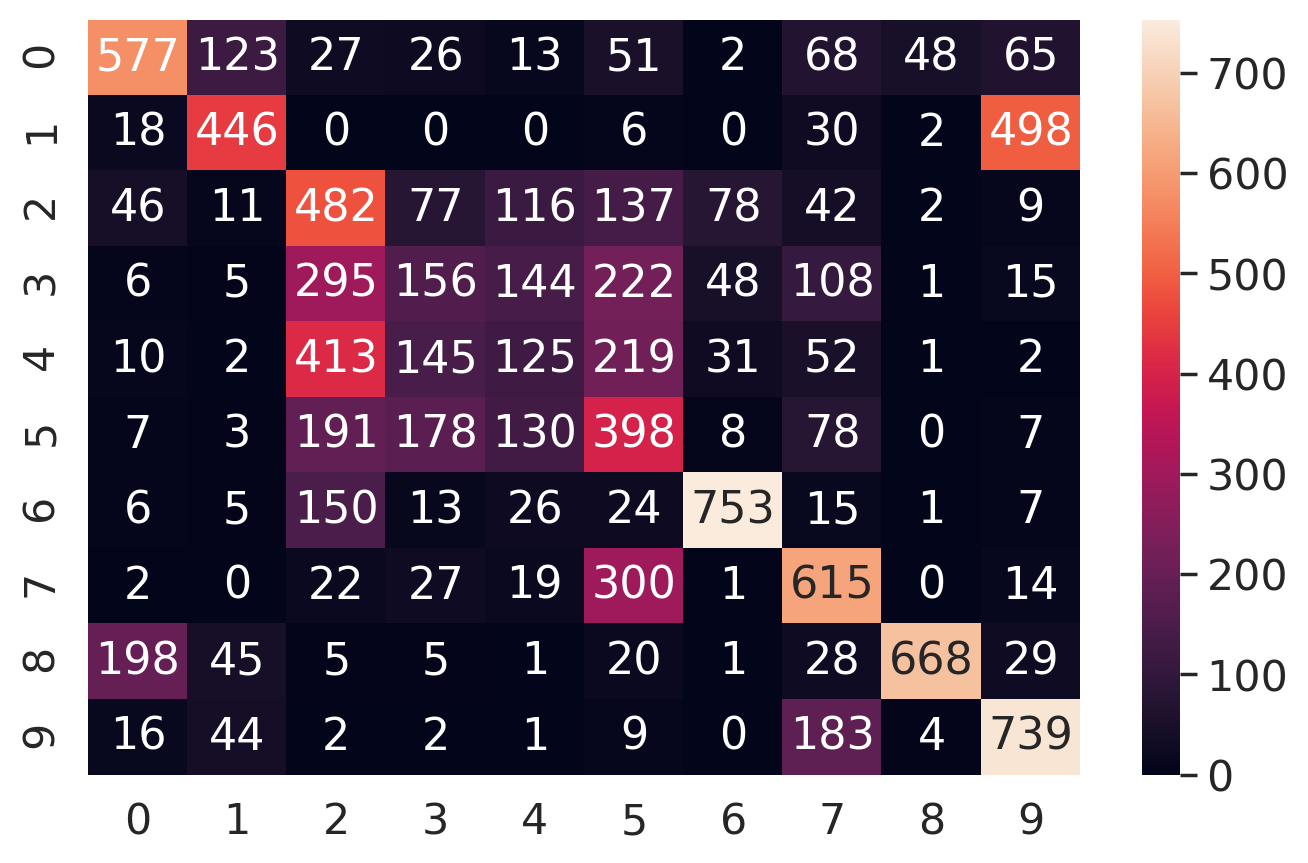

In [ ]:
plot_clf_report(base_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Classification accuracy: 0.5324



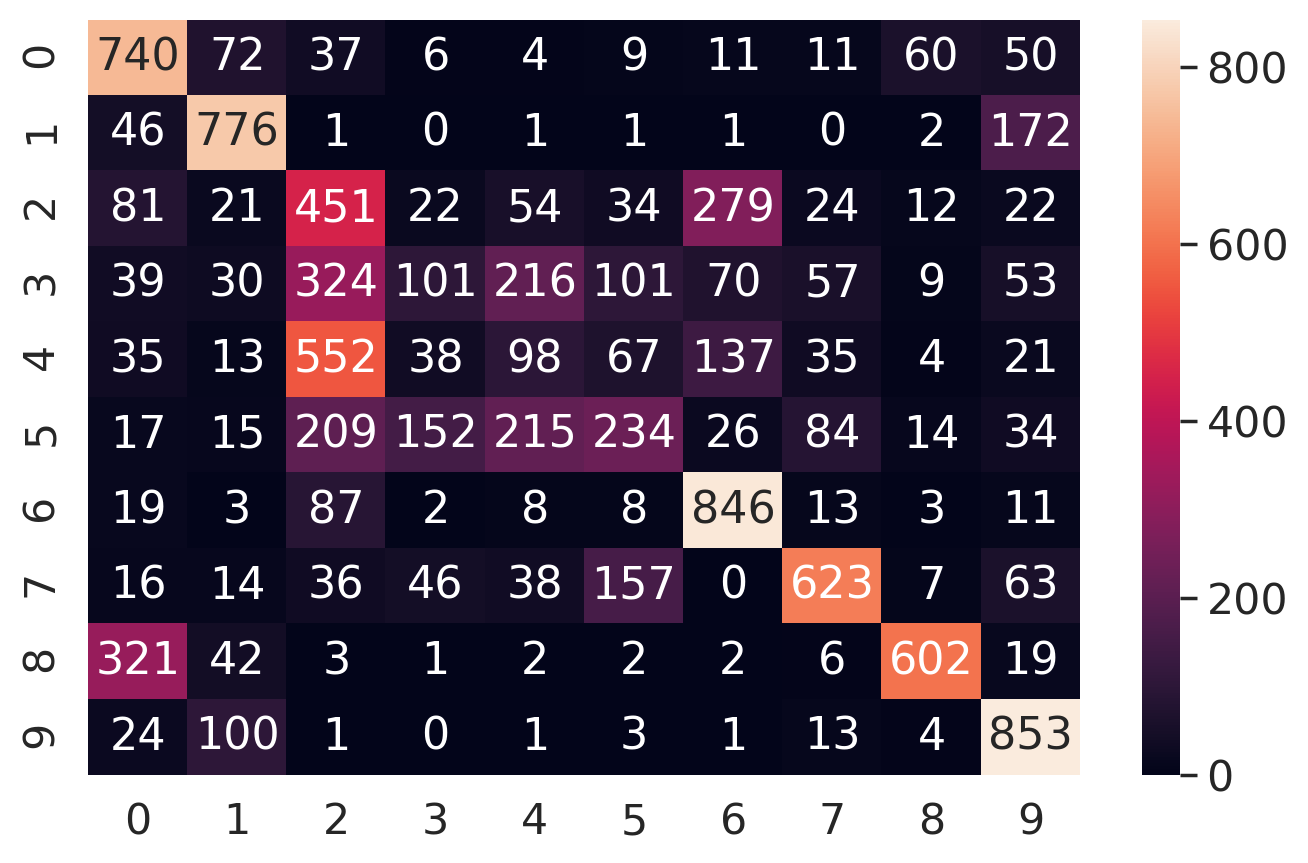

In [ ]:
plot_clf_report(transfer_model)

**4. ResNet Architecture and about deep architectures related issues**


ResNet is an architecture that won the *ImageNet challenge* in 2015. The architecture is based on the principle of *Residual learning*, aiming at learning the difference between the input and the desired output, rather than a complete mapping function. This principle, based on updates, works similarly to the *GRU* unit in Reccurent NN's, and brings the advantage of solving the *vanishing* gradients problems, being able to train deeper architectures.

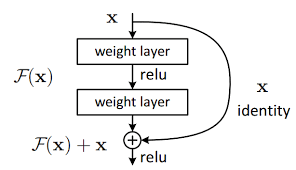

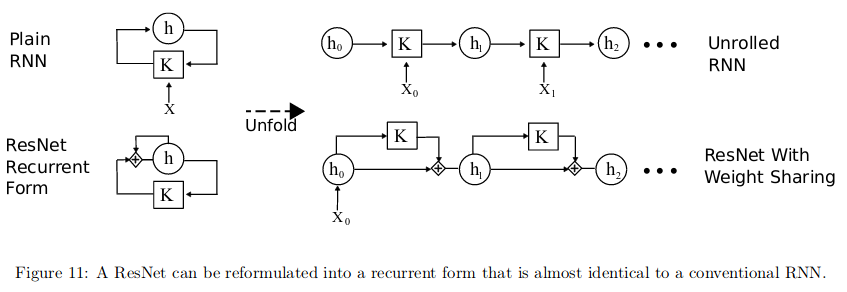

**References**
* [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)
* [ResNet in Keras](https://keras.io/api/applications/resnet/)
* [ResNet vs RNN's](https://arxiv.org/pdf/1604.03640v1.pdf)

In [ ]:
from keras.applications.resnet50 import ResNet50


# in this task, we will use the feature extraction of to train for CIFAR10 classification
# to get a better behaviour in the early stage, the classification stage will be initializaed  
# with the weights learnt on ImageNet
# then, we will observe the effect on ResNet of various optimization methods that can be used
# to find the best solution

model_resnet = ResNet50(include_top=False, weights='imagenet',input_shape=(32,32,3),classes=Y_train.shape[1])
model_resnet_sgd = add_fc_clf_stage(model_resnet)
model_resnet_sgd.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

sgd_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test), verbose=True)]
model_resnet_sgd.fit(X_train, Y_train, epochs=50, callbacks=sgd_callbacks)

Epoch 1/50
1563/1563 [==============================] - 119s 40ms/step - loss: 2.4750 - accuracy: 0.2071
E: 0 - Train - Test loss: 1.3680559396743774 - 1.3879209756851196, acc: 0.49983999133110046 - 0.49459999799728394
Epoch 2/50
1563/1563 [==============================] - 61s 39ms/step - loss: 1.4538 - accuracy: 0.4735
E: 1 - Train - Test loss: 1.0278735160827637 - 1.0850869417190552, acc: 0.637220025062561 - 0.6157000064849854
Epoch 3/50
1563/1563 [==============================] - 61s 39ms/step - loss: 1.1213 - accuracy: 0.6220
E: 2 - Train - Test loss: 0.8570266962051392 - 0.9510365128517151, acc: 0.7074000239372253 - 0.6753000020980835
Epoch 4/50
1563/1563 [==============================] - 61s 39ms/step - loss: 0.9274 - accuracy: 0.6973
E: 3 - Train - Test loss: 0.7077349424362183 - 0.8589448928833008, acc: 0.7618799805641174 - 0.7057999968528748
Epoch 5/50
1563/1563 [==============================] - 61s 39ms/step - loss: 0.7855 - accuracy: 0.7535
E: 4 - Train - Test loss: 0.75

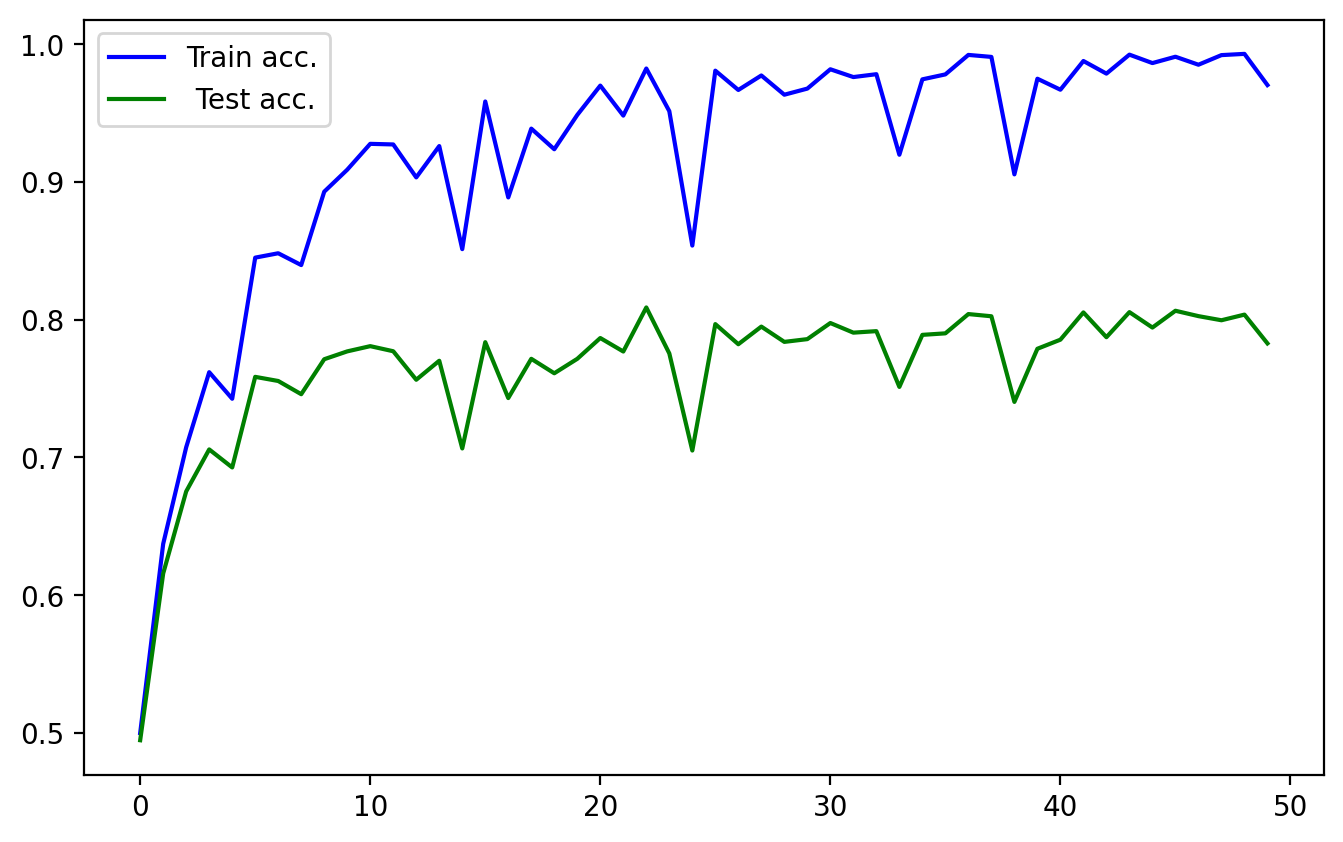

In [ ]:
cb = sgd_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')
plt.legend()

In [ ]:
model_resnet = ResNet50(include_top=False, weights='imagenet',input_shape=(32,32,3),classes=Y_train.shape[1])
model_resnet_adam = add_fc_clf_stage(model_resnet)
model_resnet_adam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

adam_callbacks = [TestCallback((X_train, Y_train), (X_test, Y_test), verbose=True)]
model_resnet_adam.fit(X_train, Y_train, epochs=50, callbacks=adam_callbacks)

Epoch 1/50
1563/1563 [==============================] - 73s 42ms/step - loss: 2.2737 - accuracy: 0.2531
E: 0 - Train - Test loss: 1.4190043210983276 - 1.452256679534912, acc: 0.5143200159072876 - 0.503000020980835
Epoch 2/50
1563/1563 [==============================] - 66s 42ms/step - loss: 1.3422 - accuracy: 0.5424
E: 1 - Train - Test loss: 1.4192664623260498 - 1.4645674228668213, acc: 0.4962800145149231 - 0.48809999227523804
Epoch 3/50
1563/1563 [==============================] - 66s 42ms/step - loss: 1.2546 - accuracy: 0.5760
E: 2 - Train - Test loss: 0.97214275598526 - 1.0502361059188843, acc: 0.6713600158691406 - 0.6409000158309937
Epoch 4/50
1563/1563 [==============================] - 66s 42ms/step - loss: 1.1662 - accuracy: 0.6083
E: 3 - Train - Test loss: 0.8759354948997498 - 0.937329113483429, acc: 0.6980400085449219 - 0.6780999898910522
Epoch 5/50
1563/1563 [==============================] - 65s 42ms/step - loss: 1.1521 - accuracy: 0.6114
E: 4 - Train - Test loss: 1.04775869

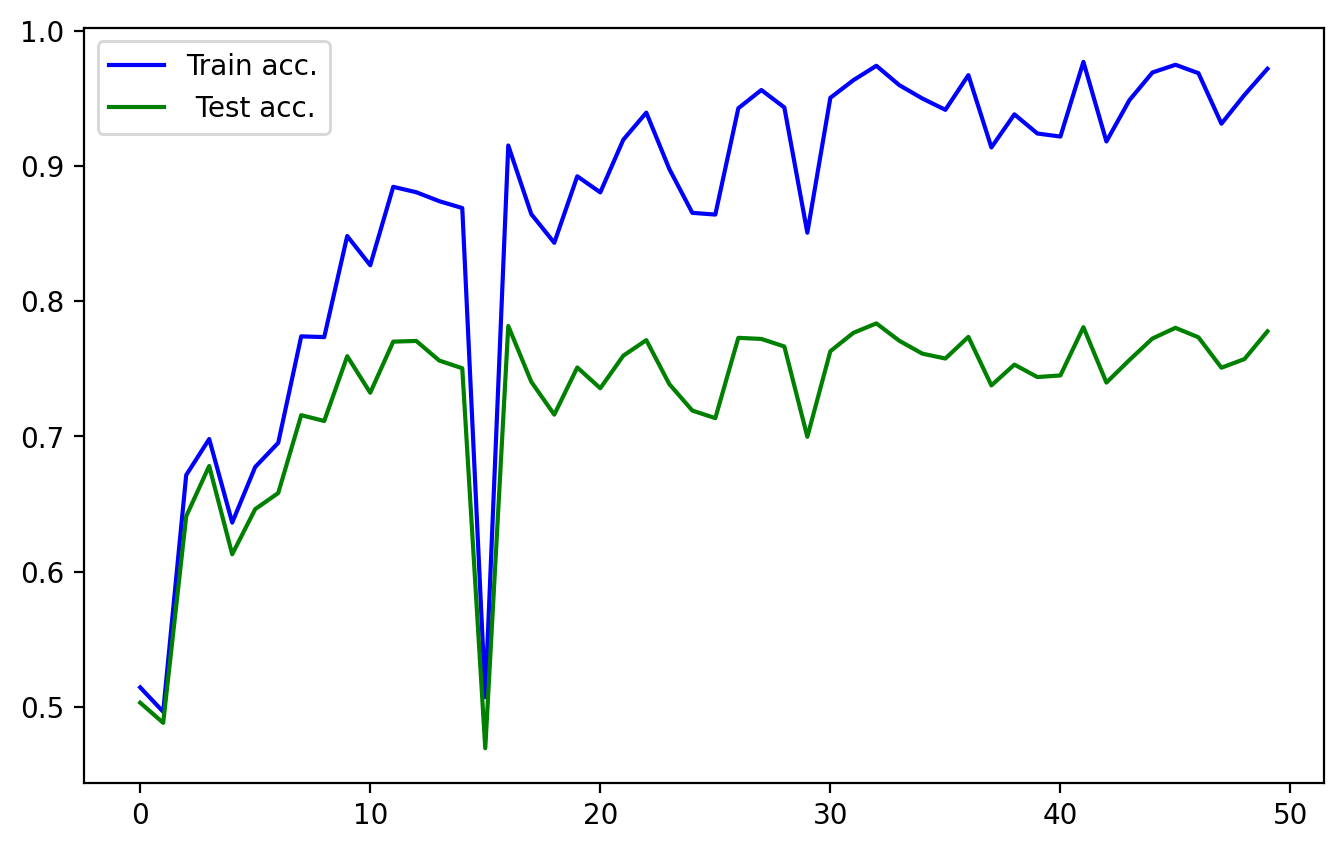

In [ ]:
cb = adam_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), label='Train acc.', c='blue')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()), label=' Test acc.', c='green')
plt.legend()

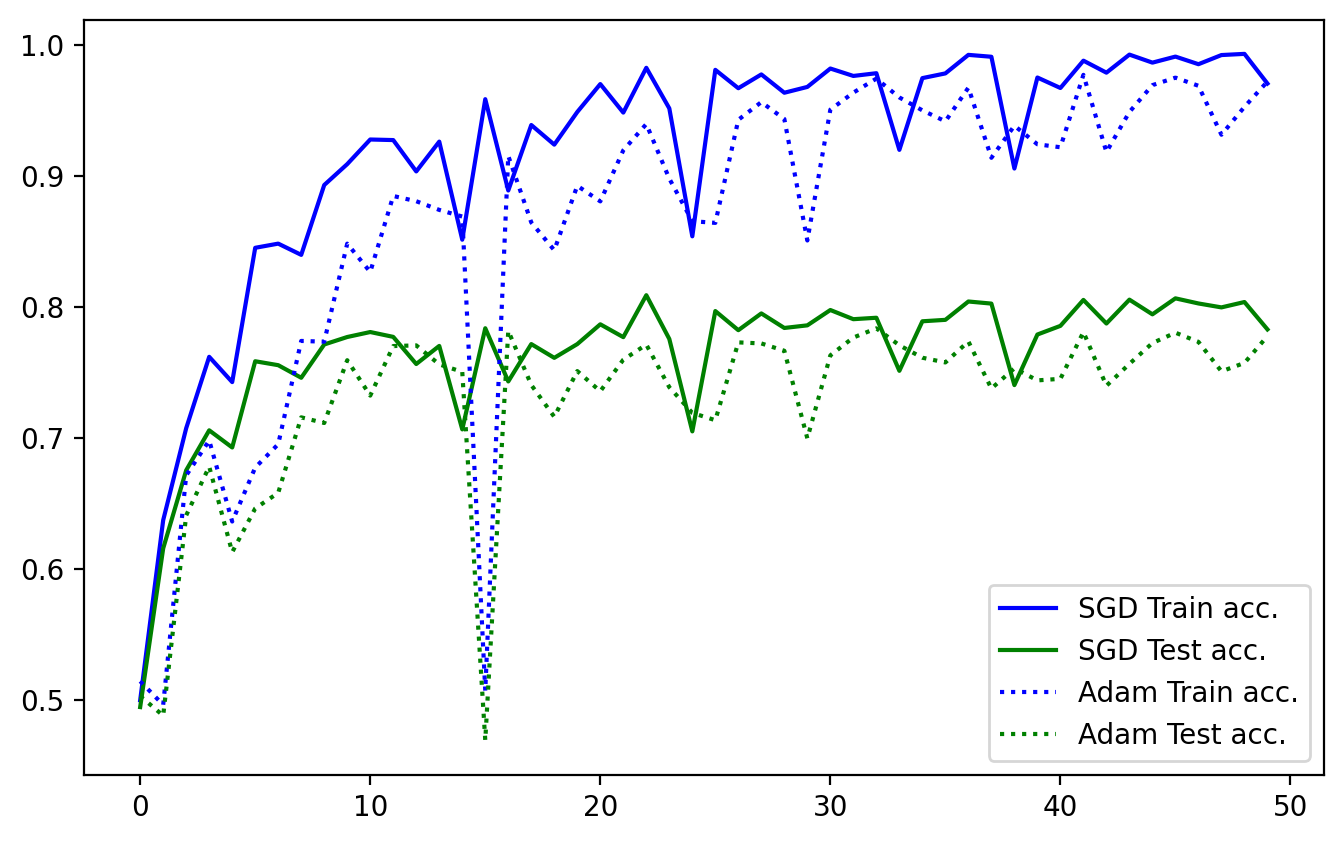

In [ ]:
cb = sgd_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b-', label='SGD Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()),'g-', label='SGD Test acc.')

cb = adam_callbacks[0]
plt.plot(list(cb.train_log.keys()), list(cb.train_log.values()), 'b:', label='Adam Train acc.')
plt.plot(list(cb.test_log.keys()), list(cb.test_log.values()),'g:', label='Adam Test acc.')
plt.legend()